In [1]:
!export HF_HOME=/run/media/anton/hdd/hf

/home/anton/source/torch-env/lib/python3.12/site-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

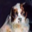

In [2]:
import os
import diffusers
import torch

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.autograd.functional import jacobian

import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt

from diffusers import DDPMPipeline, UNet2DModel

from urllib.request import urlopen 
import json 

os.environ['HF_HOME'] = "/run/media/anton/hdd/hf"

device = "cuda:0" if torch.cuda.is_available() else "cpu"

model_id = "google/ddpm-cifar10-32"

ddpm = DDPMPipeline.from_pretrained(model_id) 
ddpm = ddpm.to(device)
image = ddpm().images[0]
image.save("ddpm_cifar10_generated.png")
image

## Sample data

In [105]:
#cifar10 = load_dataset("uoft-cs/cifar10", split = "train", cache_dir="/run/media/anton/hdd/hf", streaming=True)
#training_data_loader = DataLoader(dataset_train, batch_size=1, shuffle=True)
#image, y = next(iter(training_data_loader))

#image = image.to(device)

from torchvision.transforms import Compose, PILToTensor, ConvertImageDtype


def transform(image):
    transform = Compose([
        PILToTensor(),
        ConvertImageDtype(torch.float)
    ])
    return transform(image)

image = transform(image)

image = image[None, :]

# image = image[0]

plt.imshow(np.moveaxis(image[0].cpu().numpy(), 0, -1))

image = image.to(device)

TypeError: pic should be PIL Image. Got <class 'torch.Tensor'>

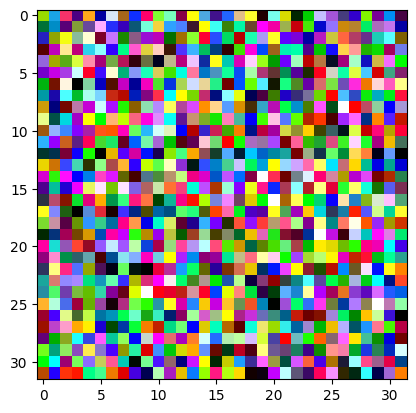

In [4]:
beta_start=1e-4
beta_end=2e-2
steps=1000
t=900

betas = torch.arange(start=beta_start, end=beta_end, step=(beta_end - beta_start)/steps)
alphas = 1 - betas
alphas_prod = torch.cumprod(alphas, dim=0).to(device)

def add_noise(image, t, rescaled=False, return_beta=False):

    noise = torch.randn(image.shape).to(device)

    # image_scaled = 2 * image - 1

    image_noisy = torch.sqrt(alphas_prod[t]) * image_scaled + torch.sqrt(1 - alphas_prod[t]) * noise

    if rescaled:
        image_noisy = torch.clip(image_noisy / 2 + 0.5, min=0, max=1)

    if return_beta:
        return image_noisy, betas[t]
    
    return image_noisy


image_noisy = add_noise(image=image, t=t, rescaled=True)

plt.imshow(np.moveaxis(image_noisy[0].cpu().numpy(), 0, -1))

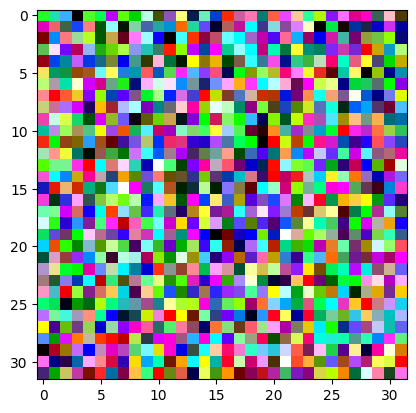

In [5]:
def denoise(image_noisy, t, rescaled=True):
    ## noisy image should be scaled [-1,1] 
    noise_pred = ddpm.unet(image_noisy, t).sample 

    mu_t = (1 / torch.sqrt(alphas[t])) * (image_noisy - (betas[t] / torch.sqrt(1 - alphas_prod[t])) * noise_pred)

    if rescaled: 
        return torch.clip(mu_t / 2 + 0.5, min=0, max=1)

    return mu_t

image_noisy = add_noise(image=image, t=t, rescaled=False)
image_denoised = denoise(image_noisy, t, rescaled=True)

plt.imshow(np.moveaxis(image_denoised[0].detach().cpu().numpy(), 0, -1))

## Generation

In [23]:
def show_image(image, rescale=True):
    if type(image) == torch.tensor:
        image = (image[0] / 2 + 0.5).detach().cpu().numpy()
    if len(image.shape) == 4:
        image = image[0]
    if rescale:
        image = image / 2 + 0.5
        
    plt.imshow(np.moveaxis(image.detach().cpu().numpy(), 0, -1))

In [79]:
def get_noise():
    return torch.randn((1,3,32,32)).to(device)

def generate():

    x_prev = torch.clip(get_noise(), -1, 1)
    
    ddpm.unet.eval()
    
    for t in reversed(range(1000)):
        
        if t > 0:
            z = get_noise()
        else:
            z = torch.zeros((1, 3,32,32)).to(device)
    
        with torch.no_grad():
            eps = ddpm.unet(x_prev, t).sample 
    
        eps_coeff = (betas[t]) / torch.sqrt(1 - alphas_prod[t]) 
    
        mu = (1 / torch.sqrt(alphas[t])) * (x_prev - eps_coeff * eps)
    
        #mu = torch.clip(mu, -1, 1)
    
        # x_new = torch.clip(mu + torch.sqrt(betas[t]) * z, -1, 1)
        x_new = mu + torch.sqrt(betas[t]) * z
        
        x_prev = x_new

    return x_new

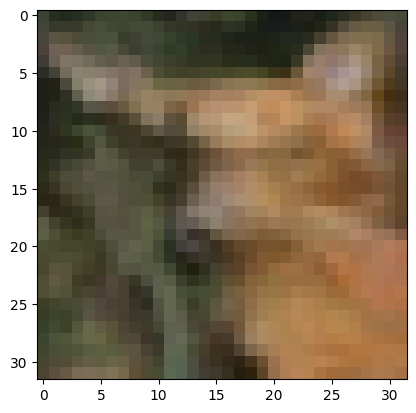

In [80]:
x_new = generate()
plt.imshow(np.moveaxis((x_new[0] / 2 + 0.5).detach().cpu().numpy(), 0, -1))

In [81]:
def generate_from(x, T):
    
    x_prev = x
    
    ddpm.unet.eval()
    
    for t in reversed(range(0, T)):
        
        if t > 0:
            z = get_noise()
        else:
            z = torch.zeros((1, 3,32,32)).to(device)
    
        with torch.no_grad():
            eps = ddpm.unet(x_prev, t).sample 
    
        eps_coeff = (betas[t]) / torch.sqrt(1 - alphas_prod[t]) 
    
        mu = (1 / torch.sqrt(alphas[t])) * (x_prev - eps_coeff * eps)
    
        #mu = torch.clip(mu, -1, 1)
    
        # x_new = torch.clip(mu + torch.sqrt(betas[t]) * z, -1, 1)
        x_new = mu + torch.sqrt(betas[t]) * z
        
        x_prev = x_new

    return x_new

def add_noise(image, t, rescaled=False):

    noise = torch.randn(image.shape).to(device)

    image_noisy = torch.sqrt(alphas_prod[t]) * image + torch.sqrt(1 - alphas_prod[t]) * noise

    if rescaled:
        image_noisy = torch.clip(image_noisy / 2 + 0.5, min=0, max=1)
    
    return image_noisy

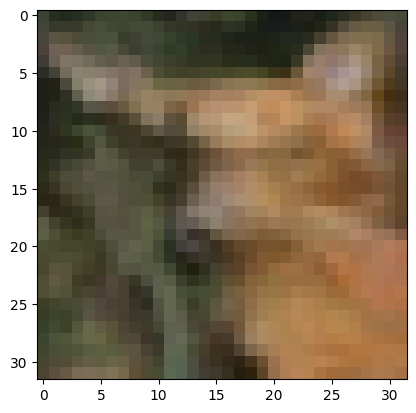

In [82]:
show_image(x_new)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0938393..2.0886948].


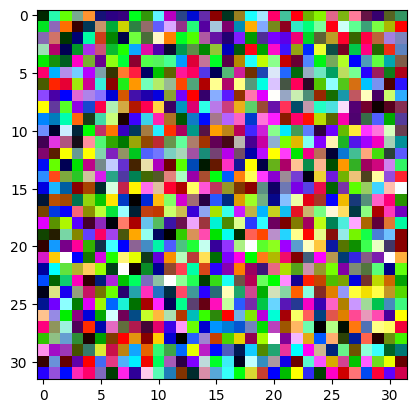

In [100]:
x_new_noisy = add_noise(x_new, t=500)
show_image(x_new_noisy, rescale=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0022201538..0.669101].


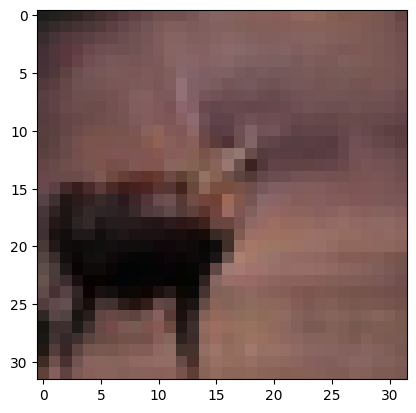

In [104]:
T_regen = 500

x_regen = generate_from(add_noise(x_new, t=T_regen), T_regen)

show_image(x_regen, rescale=True)